# Modeling and Tuning

This notebook focuses on training, evaluating, and comparing multiple classification models.  
The workflow includes:

1. Loading preprocessed training and test datasets  
2. Training baseline models (Naive Bayes and Random Forest)  
3. Evaluating model performance using Accuracy, F1-score, Confusion Matrix, and ROC-AUC  
4. Hyperparameter tuning using GridSearchCV  
5. Comparing baseline vs tuned models  
6. Final comparison between different model families  

The goal is to select the best-performing model based on both classification metrics and ROC curve analysis.


In [174]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from Trinity import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_curve, 
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    f1_score
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


## Loading the Data

Here we load the preprocessed datasets:
- training dataset
- test dataset
- scaled dataset for future predictions

All datasets were prepared in earlier preprocessing steps.


In [286]:
full_training_data_wt = pd.read_csv('Nata_Files/processed/train_dataset.csv', index_col=0)
training_data_wt = pd.read_csv('Nata_Files/less_features/train_data_lf.csv', index_col=0)
full_testing_data_wt = pd.read_csv('Nata_Files/processed/test_dataset.csv', index_col=0)
testing_data_wt = pd.read_csv('Nata_Files/less_features/test_data_lf.csv', index_col=0)
full_prediction_data = pd.read_csv('Nata_Files/processed/pred_scaled.csv', index_col=0)
prediction_data = pd.read_csv('Nata_Files/less_features/pred_data_lf.csv', index_col=0)

## Train/Test Feature Separation

In this step, we separate:
- input features (X)
- target variable (y)

This is done for both training and test datasets where feature selection was done and for the preprocessed dataset with all features (for the Random Forest).


In [395]:
X_train_af = full_training_data_wt.drop(['oven_temp', 'target'], axis=1) #dropping redundant feature
X_train_lf = training_data_wt.drop('target', axis=1)
prediction_data_af = full_prediction_data.drop('oven_temp', axis=1)
prediction_data_lf = prediction_data.drop('target', axis=1)
y_train = full_training_data_wt['target']
X_test_af = full_testing_data_wt.drop(['oven_temp', 'target'], axis=1) #dropping redundant feature
X_test_lf = testing_data_wt.drop('target', axis=1)
y_test = full_testing_data_wt['target']
#somewhere along the line we discovered that adding egg_temp back in can slightly increase the performance of the MLPClassifier
X_train_mlp=X_train_lf.join(X_train_af['egg_temp'])
X_test_mlp = X_test_lf.join(X_test_af['egg_temp'])
prediction_data_mlp = prediction_data_lf.join(prediction_data_af['egg_temp'])

## Naive Bayes Classifier - Baseline Model

We start with a Gaussian Naive Bayes classifier as a baseline model.  
This model is simple, fast, and provides a good reference point for more complex models.  

Accuracy: 0.7182692307692308
F1 Score: 0.7169552399065005


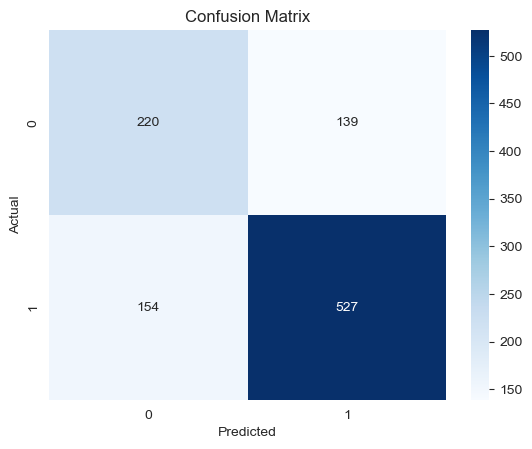

In [178]:
gnb = GaussianNB()
gnb.fit(X_train_lf, y_train)
predicted = gnb.predict(X_test_lf)
y_pred = gnb.predict(X_test_lf)

# Compute evaluation metrics for baseline Naive Bayes
accuracy = accuracy_score(y_pred, y_test)
f1gnb = f1_score(y_pred, y_test, average="weighted")

print("Accuracy:", accuracy)
print("F1 Score:", f1gnb)

# Visualize classification errors using confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Hyperparameter Tuning - Naive Bayes

We use a for loop to find the optimal value of the `var_smoothing`
parameter.
The weighted F1-score is used as the optimization metric.

In [141]:
var_smoothing_values = np.logspace(-12, -6, 50)

results = {'var_smoothing': [],'train_f1_weighted': [],'test_f1_weighted': []}

for smoothing_value in var_smoothing_values:

    gnb = GaussianNB(var_smoothing=smoothing_value)
    gnb.fit(X_train_lf, y_train)
    y_train_pred = gnb.predict(X_train_lf)
    train_score = f1_score(y_train, y_train_pred, average='weighted')
    y_test_pred = gnb.predict(X_test_lf)
    test_score = f1_score(y_test, y_test_pred, average='weighted')
    results['var_smoothing'].append(smoothing_value)
    results['train_f1_weighted'].append(train_score)
    results['test_f1_weighted'].append(test_score)

results_df = pd.DataFrame(results)
best_row = results_df.loc[results_df['test_f1_weighted'].idxmax()]
print("\n--- Results Summary ---")
print(results_df.sort_values('test_f1_weighted', ascending=True).head())
print("\n--- Best Variance Smoothing (Based on Test Score) ---")
print(f"Best var_smoothing: {best_row['var_smoothing']:.2e}")
print(f"Train F1-weighted: {best_row['train_f1_weighted']:.4f}")
print(f"Test F1-weighted: {best_row['test_f1_weighted']:.4f}")


--- Results Summary ---
    var_smoothing  train_f1_weighted  test_f1_weighted
0    1.000000e-12           0.706449          0.719583
27   2.023590e-09           0.706449          0.719583
28   2.682696e-09           0.706449          0.719583
29   3.556480e-09           0.706449          0.719583
30   4.714866e-09           0.706449          0.719583

--- Best Variance Smoothing (Based on Test Score) ---
Best var_smoothing: 1.00e-12
Train F1-weighted: 0.7064
Test F1-weighted: 0.7196


## Naive Bayes - Tuned Model

Using the best variance smoothing we found during the search,
we retrain the Naive Bayes model and evaluate its performance
on the test dataset.


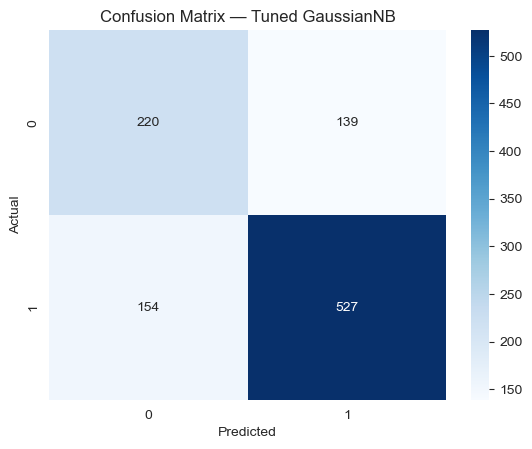

In [142]:
best_var = 1.00e-12 # Train Naive Bayes model using optimal hyperparameter

gnb_new = GaussianNB(var_smoothing=best_var)
gnb_new.fit(X_train_lf, y_train)

y_pred_gnb_new = gnb_new.predict(X_test_lf) # Predict with tuned model

accuracy_gnb_new = accuracy_score(y_test, y_pred_gnb_new)
f1_gnb_new = f1_score(y_test, y_pred_gnb_new, average='weighted')

cm = confusion_matrix(y_test, y_pred_gnb_new)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix — Tuned GaussianNB')
plt.show()

In [143]:
print(f"The new Gaussian Naive Bayes model with adjusted variance smoothing has:\na training score of {round(100*gnb_new.score(X_train_lf, y_train),1)}% \n"
      f"and a test score of {round(100*gnb_new.score(X_test_lf, y_test),1)}%")

The new Gaussian Naive Bayes model with adjusted variance smoothing has:
a training score of 70.5% 
and a test score of 71.8%


## ROC Curve - Naive Bayes

This section compares the baseline and tuned Naive Bayes models using ROC curves and AUC scores and as it turns out the optimal Variance Smoothing coefficient was the same as in the base model leaving us with a single line in the ROC Curve.


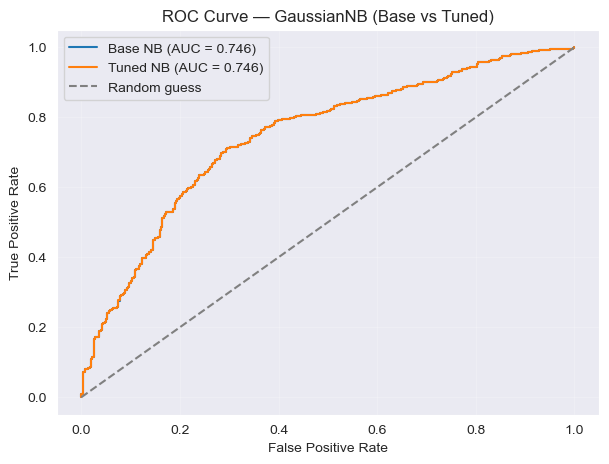

In [144]:
# Convert target labels to binary format for ROC analysis
y_train_bin = y_train.map({'OK': 1, 'KO': 0})
y_test_bin  = y_test.map({'OK': 1, 'KO': 0}) 

# Obtain predicted probabilities for positive class
y_proba_nb_base = gnb.predict_proba(X_test_lf)[:, 1]
y_proba_nb_tuned = gnb_new.predict_proba(X_test_lf)[:, 1]

fpr_nb_base, tpr_nb_base, _ = roc_curve(y_test_bin, y_proba_nb_base)
fpr_nb_tuned, tpr_nb_tuned, _ = roc_curve(y_test_bin, y_proba_nb_tuned)

auc_nb_base = roc_auc_score(y_test_bin, y_proba_nb_base)
auc_nb_tuned = roc_auc_score(y_test_bin, y_proba_nb_tuned)

plt.figure(figsize=(7, 5))
plt.plot(fpr_nb_base, tpr_nb_base, label=f'Base NB (AUC = {auc_nb_base:.3f})')
plt.plot(fpr_nb_tuned, tpr_nb_tuned, label=f'Tuned NB (AUC = {auc_nb_tuned:.3f})')
plt.plot([0, 1], [0, 1], '--', color='grey', label='Random guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — GaussianNB (Base vs Tuned)')
plt.legend()
plt.grid(alpha=0.2)
plt.show()


## Logistic Regression - Baseline Model

Just for reference we also checked how a simple Linear Regression Model would perform and as it turns out it seems quite decent with very little overfitting. Considering the simplicity of the model we manually tried out some different Hyperparameters but found that the results stayed the same.

In [200]:
lr = LogisticRegression()
lr.fit(X_train_lf, y_train)
print(f"Training Score: {round(100*lr.score(X_train_lf, y_train),2)}\nValidation Score: {round(100*lr.score(X_test_lf, y_test),2)}")

Training Score: 75.05
Validation Score: 74.04


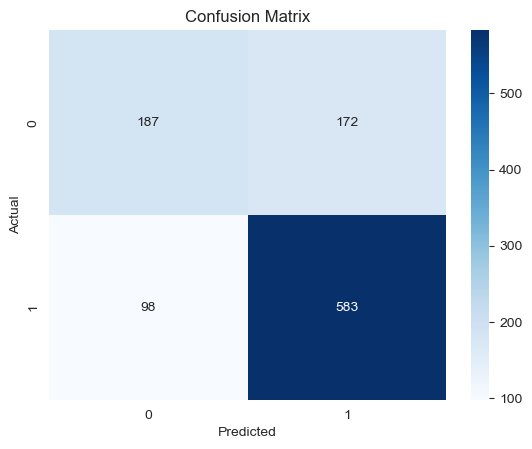

In [201]:
y_pred_lr = lr.predict(X_test_lf)

accuracy_rf = accuracy_score(y_test, y_pred_lr)
f1_rf = f1_score(y_pred_lr, y_test, average="weighted")

# Evaluate Random Forest predictions using confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Random Forest Classifier - Baseline Model

Next, we train a Random Forest classifier.  
This ensemble model is expected to capture more complex non-linear relationships in the data.

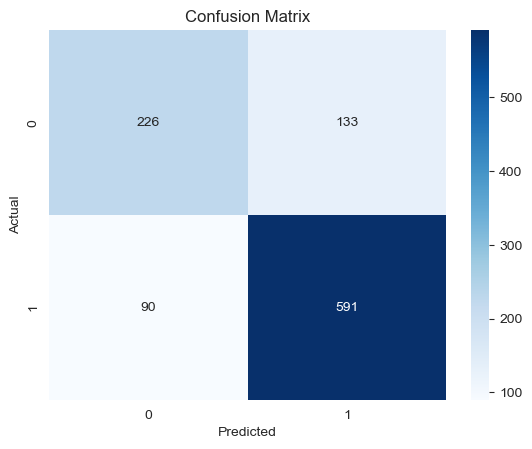

In [387]:
rf = RandomForestClassifier() # Initialize Random Forest with default parameters

rf.fit(X_train_af, y_train)
y_pred_rf = rf.predict(X_test_af)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_pred_rf, y_test, average="weighted")

# Evaluate Random Forest predictions using confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [388]:
rf.score(X_train_af, y_train), rf.score(X_test_af, y_test)

(1.0, 0.7855769230769231)

## Hyperparameter Tuning - Random Forest

We perform hyperparameter tuning using GridSearchCV to optimize model complexity and reduce overfitting. We chose to only use 2 folds on the Cross validation considering the data leakage, increasing the number of $K$ folds beyond a small number would not significantly change the outcome because all $K$ validation scores will be inflated by the same fundamental bias, and they will therefore not lead to a more accurate selection of the best hyperparameter. In addition to the CVGridSearch we also ran a loop to test different numbers of maximum leaf nodes.

In [381]:
# Define hyperparameter grid for Random Forest optimization
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
}

grid_search  = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=2)
grid_search.fit(X_train_af, y_train)
print(grid_search.best_estimator_)

print("Best Parameters:", grid_search.best_params_)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=5, random_state=42)
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


We use the Hyperparameters from the grid search to calculate the f1 score as the maximum number of leaf nodes increases from 2 to 202.

In [163]:
def calculate_F1(X_train, y_train, X_test, y_test, interval):
    """
    Trains RandomForestClassifiers for different max_leaf_nodes values on
    a fixed training set and evaluates on a fixed test set.
    """
    y_train_mapped = y_train.map({'OK': 1, 'KO': 0})
    y_test_mapped = y_test.map({'OK': 1, 'KO': 0})

    train_results = []
    test_results = []
    for value in interval:
        rf = RandomForestClassifier(max_leaf_nodes=int(value),min_samples_split=5, min_samples_leaf=2, n_estimators=100, random_state=42)
        rf.fit(X_train, y_train_mapped)
        # --- Train Score ---
        train_pred = rf.predict(X_train)
        f1_train = f1_score(y_train_mapped, train_pred)
        train_results.append(round(f1_train, 3))
        # --- Test Score ---
        test_pred = rf.predict(X_test)
        f1_test = f1_score(y_test_mapped, test_pred)
        test_results.append(round(f1_test, 3))

    best_train_index = np.argmax(train_results)
    best_test_index = np.argmax(test_results)

    best_train_value = interval[best_train_index]
    best_test_value = interval[best_test_index]

    selected_positions = interval[::10]

    print(f'The best F1 score for train is {max(train_results)} with {best_train_value} Max Leaf Nodes')
    print(f'The best F1 score for test is {max(test_results)} with  {best_test_value} Max Leaf Nodes')

    plt.figure(figsize=(10, 6))
    plt.plot(interval, train_results, label="Train F1")
    plt.plot(interval, test_results, label="Test F1")

    plt.xticks(selected_positions)
    plt.legend()
    plt.ylabel("F1 score")
    plt.xlabel('Max Leaf Nodes')
    plt.title(f"Random Forest Performance vs Max Leaf Nodes")
    plt.grid(True)
    plt.show()

We can see the divergence between training score and testing score with a maximum number of leaf nodes around 22 after this split we can clearly see overfitting.

The best F1 score for train is 0.934 with 201 Max Leaf Nodes
The best F1 score for test is 0.844 with  164 Max Leaf Nodes


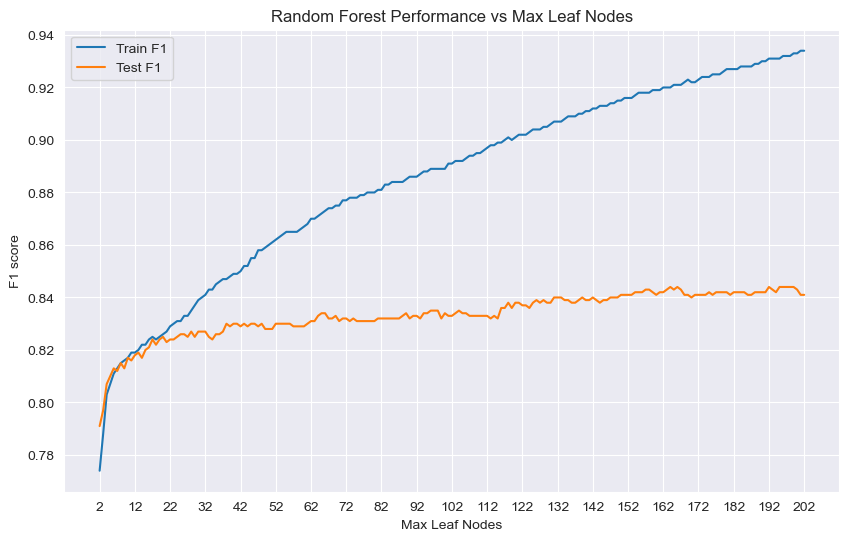

In [382]:
calculate_F1(X_train_af, y_train,X_test_af,y_test, np.arange(2, 203))

## Random Forest - Tuned Model

The Random Forest model is retrained using the optimal hyperparameters obtained from grid search and the maximum leaf node search and as it turns out the model performs better without any hyperparameters and with maximum overfitting.

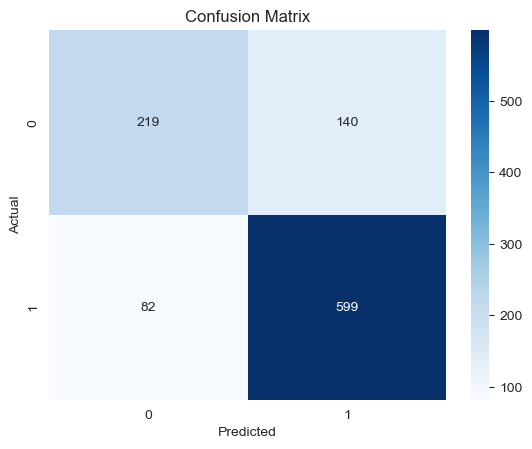

In [383]:
# Retrain Random Forest using selected hyperparameters
rf_new = RandomForestClassifier(
n_estimators=100,
max_leaf_nodes=164,
min_samples_split=5,
min_samples_leaf=2,
random_state=42)

rf_new.fit(X_train_af, y_train)
y_pred_rf_new = rf_new.predict(X_test_af)

accuracy_rf_new = accuracy_score(y_test, y_pred_rf_new)
f1_rf_new = f1_score(y_pred_rf_new, y_test, average="weighted")

cm = confusion_matrix(y_test, y_pred_rf_new)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [379]:
print(f"The best Random Forest model with adjusted parameters has:\na training score of {round(100*rf_new.score(X_train_af, y_train),1)}% \n"
      f"and a test score of {round(100*rf_new.score(X_test_af, y_test),1)}%")

The best Random Forest model with adjusted parameters has:
a training score of 89.6% 
and a test score of 78.7%


## ROC Curve - Random Forest

This section compares the baseline and tuned Random Forest models using ROC curves and AUC scores. To our surprise the base model seemed to display a better ROC-curve in comparison to our tuned model signifying that the model was better when it was allowed to overfit.


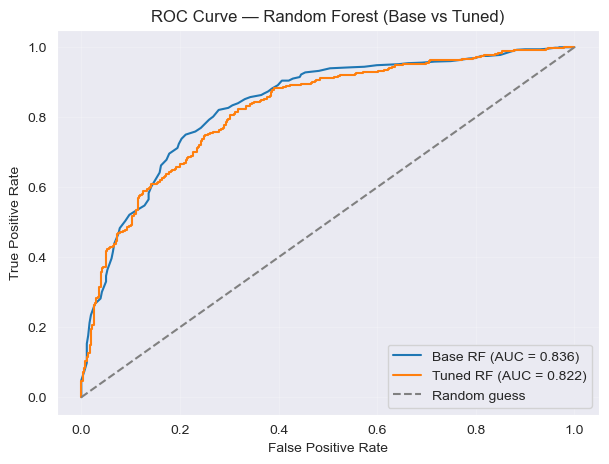

In [389]:
y_train_bin = y_train.map({'OK': 1, 'KO': 0})
y_test_bin  = y_test.map({'OK': 1, 'KO': 0})

y_proba_rf_base = rf.predict_proba(X_test_af)[:, 1]
y_proba_rf_tuned = rf_new.predict_proba(X_test_af)[:, 1]

fpr_base, tpr_base, _ = roc_curve(y_test_bin, y_proba_rf_base)
fpr_tuned, tpr_tuned, _ = roc_curve(y_test_bin, y_proba_rf_tuned)

auc_base = roc_auc_score(y_test_bin, y_proba_rf_base)
auc_tuned = roc_auc_score(y_test_bin, y_proba_rf_tuned)

plt.figure(figsize=(7, 5))
plt.plot(fpr_base, tpr_base, label=f'Base RF (AUC = {auc_base:.3f})')
plt.plot(fpr_tuned, tpr_tuned, label=f'Tuned RF (AUC = {auc_tuned:.3f})')
plt.plot([0, 1], [0, 1], '--', color='grey', label='Random guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Random Forest (Base vs Tuned)')
plt.legend()
plt.grid(alpha=0.2)
plt.show()


## MLPCLassifier - Baseline Model
We were also interested in the performance of the Multi Layer Perception of sklearn and got pretty good results right off the bat but were not convinced that those were the best results we could get out of the MLP.

In [374]:
mlp = MLPClassifier()
mlp.fit(X_train_mlp, y_train)
print(f"Training Score: {round(100*mlp.score(X_train_mlp, y_train),2)}%\nValidation Score: {round(100*mlp.score(X_test_mlp, y_test),2)}%")

Training Score: 77.95%
Validation Score: 76.35%


## MLPClassifier - Dimension Comparison
We tested a bunch of combinations of neurons and layers to see whether there would be a specific type of combination that would yield better results, as it turns out there is not. Depending on random state the model also tended to perform differently which made it difficult to learn anything about the data or the model.

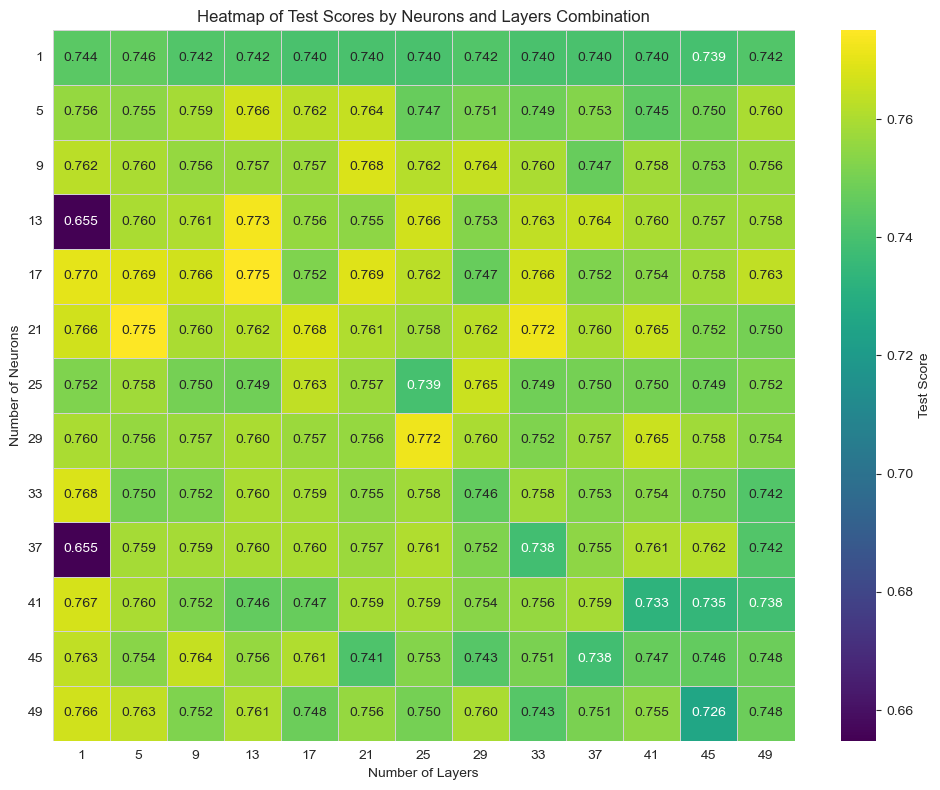

In [363]:
dict_of_scores_train = {}
dict_of_scores_test = {}
for neurons in range(1,50,4):
    for layers in range(1,50,4):
        mlp = MLPClassifier(hidden_layer_sizes=(neurons,layers), max_iter=1000, random_state=42)
        mlp.fit(X_train_mlp, y_train)
        mlp.fit(X_train_mlp, y_train)
        dict_of_scores_train[f'neurons: {neurons}, layers: {layers}'] = mlp.score(X_train_mlp, y_train)
        dict_of_scores_test[f'neurons: {neurons}, layers: {layers}'] = mlp.score(X_test_mlp, y_test)
import regex as re
data_test = pd.DataFrame(list(dict_of_scores_test.items()), columns=['combination', 'test_score'])

def extract_params(combination_str):
    match = re.search(r'neurons: (\d+), layers: (\d+)', combination_str)
    if match:
        return int(match.group(1)), int(match.group(2))
    return None, None

data_test[['neurons', 'layers']] = data_test['combination'].apply(lambda x: pd.Series(extract_params(x)))
data_test['neurons'] = data_test['neurons'].astype(int)
data_test['layers'] = data_test['layers'].astype(int)

pivot_table = data_test.pivot(index='neurons', columns='layers', values='test_score')

plt.figure(figsize=(10, 8))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt=".3f",
    cmap='viridis',
    cbar_kws={'label': 'Test Score'},
    linewidths=.5,
    linecolor='lightgray'
)

plt.title('Heatmap of Test Scores by Neurons and Layers Combination')
plt.xlabel('Number of Layers')
plt.ylabel('Number of Neurons')
plt.xticks(rotation=0)
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig('heatmap_test_scores.png')

## MLPClassifier - Tuned Model
To manage the prolonged training times of the neural networks, we focused tuning solely on the initial learning rate (ranging from 0.01 to 0.1). This step was supposed to finalize the model's structure however it did nothing to improve the model, so we just continued by adopting the optimal neuron and layer combination previously determined by the grid.

In [391]:
best_scr=0.75
best_lrt = 0.01
for i in range(1,11):
    i/=100
    mlp_test = MLPClassifier(hidden_layer_sizes=(21,5), learning_rate_init=i, max_iter=1000, random_state=42)
    mlp_test.fit(X_train_mlp, y_train)
    if mlp_test.score(X_test_mlp, y_test) > best_scr:
        best_scr = mlp_test.score(X_test_mlp, y_test)
        best_lrt = i
mlp_tuned = MLPClassifier(hidden_layer_sizes=(21,5), learning_rate_init=best_lrt, max_iter=1000, random_state=42)
mlp_tuned.fit(X_train_mlp, y_train)
print(f"Tuned Learning Rate\nLearning Rate = {best_lrt}\nTraining Score: {round(100*mlp_tuned.score(X_train_mlp, y_train),2)}%\nValidation Score: {round(100*mlp_tuned.score(X_test_mlp, y_test),2)}%\n-----------------")
mlp_best = MLPClassifier(hidden_layer_sizes=(21,5), max_iter=5000, random_state=42)
mlp_best.fit(X_train_mlp, y_train)
print(f"Base Learning Rate\nLearning Rate = base settings\nTraining Score: {round(100*mlp_best.score(X_train_mlp, y_train),2)}%\nValidation Score: {round(100*mlp_best.score(X_test_mlp, y_test),2)}%")

Tuned Learning Rate
Learning Rate = 0.05
Training Score: 78.21%
Validation Score: 76.35%
-----------------
Base Learning Rate
Learning Rate = base settings
Training Score: 77.44%
Validation Score: 77.5%


## Sklearn Model Comparison - ROC Curve

Finally, we compare the best versions of all the sklearn models using ROC curves and AUC scores to determine the overall best-performing classifier so far. From a f1-Score standpoint it seems as if the Random Forest beats all the others so we will be comparing the scores on training and testing on of all models at a later stage.

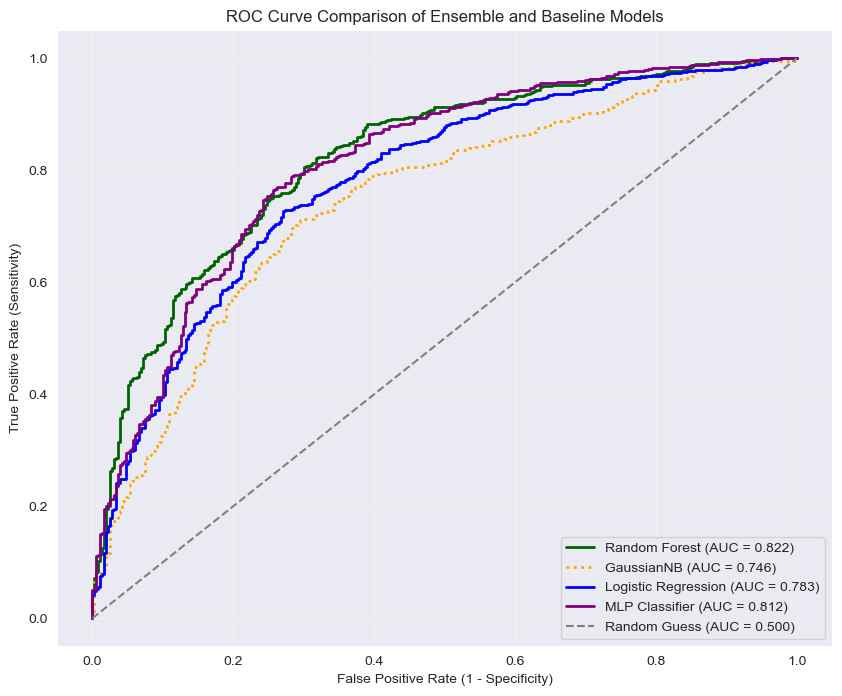

In [392]:
y_proba_lr = lr.predict_proba(X_test_lf)[:, 1]
y_proba_mlp = mlp_best.predict_proba(X_test_mlp)[:, 1]
y_proba_rf = rf_new.predict_proba(X_test_af)[:, 1]
y_proba_nb = gnb_new.predict_proba(X_test_lf)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test_bin, y_proba_lr)
auc_lr = roc_auc_score(y_test_bin, y_proba_lr)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test_bin, y_proba_mlp)
auc_mlp = roc_auc_score(y_test_bin, y_proba_mlp)
fpr_rf, tpr_rf, _ = roc_curve(y_test_bin, y_proba_rf)
fpr_nb, tpr_nb, _ = roc_curve(y_test_bin, y_proba_nb)
auc_rf = roc_auc_score(y_test_bin, y_proba_rf)
auc_nb = roc_auc_score(y_test_bin, y_proba_nb)

plt.figure(figsize=(10, 8))

plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})", linewidth=2, color='darkgreen')
plt.plot(fpr_nb, tpr_nb, label=f"GaussianNB (AUC = {auc_nb:.3f})", linewidth=2, linestyle=':', color='orange')
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.3f})", linewidth=2, color='blue')
plt.plot(fpr_mlp, tpr_mlp, label=f"MLP Classifier (AUC = {auc_mlp:.3f})", linewidth=2, color='purple')

plt.plot([0, 1], [0, 1], 'k--', color='grey', label="Random Guess (AUC = 0.500)")

plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve Comparison of Ensemble and Baseline Models")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

---

## Trinity - our own three layer MLP

Since the traditional models yielded comparable results, we explored an experimental comparison assessing how Lucas' custom 3-Layer MLP Trinity (yup, he named after the first atomic bomb) performed against these more sophisticated models. We ran Trinity with 1000 epochs instead of the default 500 epochs, a 0.1 learning rate (default), and no momentum which, proved to be the optimal configuration. Further, out of curiosity, we custom-built a Stacking Classifier with Trinity acting as the meta learner to see if an MLP could identify distinct patterns within the predictions of the weak base learners.

Trinity is configured with a learning rate decay of $0.995$ applied every epoch and maintains the same number of neurons in all hidden layers as in the first layer; it utilizes a sigmoid activation function for the first two layers and a softmax function for the final output layer.

In [400]:
tc = TrinityClassifier(len(X_train_lf.columns), 1000)
tc.train(X_train_lf, y_train)
print(f"Training Score: {round(100*tc.score(X_train_lf, y_train),2)}%\nValidation Score: {round(100*tc.score(X_test_lf, y_test),2)}%")

Epoch:    0 | Avg Error: 0.453000 | Learning Rate: 0.100000
Epoch:  100 | Avg Error: 0.341032 | Learning Rate: 0.060577
Epoch:  200 | Avg Error: 0.335892 | Learning Rate: 0.036696
Epoch:  300 | Avg Error: 0.333769 | Learning Rate: 0.022229
Epoch:  400 | Avg Error: 0.332589 | Learning Rate: 0.013466
Epoch:  500 | Avg Error: 0.331944 | Learning Rate: 0.008157
Epoch:  600 | Avg Error: 0.331573 | Learning Rate: 0.004941
Epoch:  700 | Avg Error: 0.331341 | Learning Rate: 0.002993
Epoch:  800 | Avg Error: 0.331184 | Learning Rate: 0.001813
Epoch:  900 | Avg Error: 0.331076 | Learning Rate: 0.001098

Training completed. Final learning rate: 0.000665
Training Score: 75.78%
Validation Score: 75.96%


In [339]:
dtc = DecisionTreeClassifier(max_leaf_nodes=22, random_state=42)
knn = KNeighborsClassifier(n_neighbors=10)
models = [gnb, knn, dtc, lr]

In [377]:
stc = StackingTrinity(models)
stc.train(X_train_lf, y_train)
print(f"Training Score: {round(100*stc.score(X_train_lf, y_train),2)}%\nValidation Score: {round(100*stc.score(X_test_lf, y_test),2)}%")

Model 0: [0.17729066 0.99927748 0.64553192 ... 0.77790146 0.3063803  0.97765017]
Model 1: [1.  0.9 0.4 ... 0.7 0.2 0.9]
Model 2: [0.69354839 0.91648107 0.64615385 ... 0.6635514  0.30612245 0.91648107]
Model 3: [0.63650936 0.97903093 0.50589262 ... 0.77751726 0.3207485  0.91180803]
Epoch:    0 | Avg Error: 0.448744 | Learning Rate: 0.100000
Epoch:  100 | Avg Error: 0.285987 | Learning Rate: 0.060577
Epoch:  200 | Avg Error: 0.285969 | Learning Rate: 0.036696
Epoch:  300 | Avg Error: 0.285998 | Learning Rate: 0.022229
Epoch:  400 | Avg Error: 0.286055 | Learning Rate: 0.013466

Training completed. Final learning rate: 0.008157
Training Score: 78.98%
Validation Score: 75.96%


## Conclusions about Trinity

The Trinity Classifier and its stacked counterpart, which uses Trinity as the meta-learner, produced good results comparable to the best of our traditional models. We excluded the manual parameter tests from this notebook to maintain focus, given their high computational cost and minimal added insight.

---

## Final Overview and Conclusions

In a direct comparison of performance, all developed models successfully surpassed the baseline score established by the dummy classifier. However, validation scores across the models showed only marginal differences. The Random Forest achieved the highest validation score, but this came with the largest gap between its training and validation performance, indicating significant overfitting. Conversely, the MLPClassifier and TrinityClassifier demonstrated the most consistent results overall, exhibiting the least variance between training and validation scores. The Random Forest model ultimately yielded the highest score in the Kaggle competition. Given this strong performance, we will dedicate the subsequent notebook to its final, minor hyperparameter refinement and use the resulting optimal configuration for our final predictions.

In [402]:
gnb_pred=gnb.predict(prediction_data_lf)
gnb_pred = pd.Series(gnb_pred, index=prediction_data_lf.index)
rf_pred=rf_new.predict(prediction_data_af)
rf_pred = pd.Series(rf_pred, index=prediction_data_af.index)
lr_pred = lr.predict(prediction_data_lf)
lr_pred = pd.Series(lr_pred, index=prediction_data_lf.index)
mlp_pred=mlp_best.predict(prediction_data_mlp)
mlp_pred = pd.Series(mlp_pred, index=prediction_data_lf.index)
tc_pred=tc.predict(prediction_data_lf)
stc_pred=stc.predict(prediction_data_lf)
stc_pred.index=prediction_data_lf.index

In [403]:
pred_all ={
    'GaussianNB': gnb_pred,
    'RandomForest': rf_pred,
    'LogisticRegression': lr_pred,
    'MLPClassifier': mlp_pred,
    'TrinityClassifier': tc_pred,
    'StackedTrinityClassifier': stc_pred
}
for name, pred in pred_all.items():
    pred.to_csv(f'Nata_Files/predictions/{name}.csv')

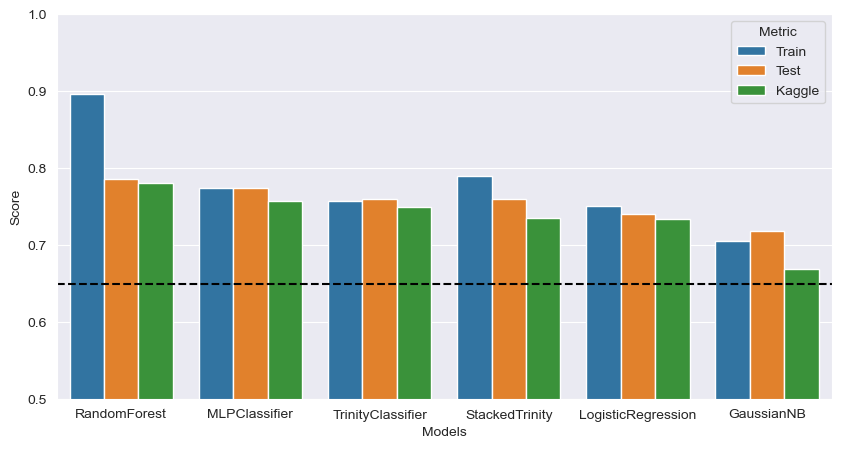

In [401]:
scores = {'GaussianNB': [gnb_new.score(X_train_lf, y_train), gnb_new.score(X_test_lf, y_test), 0.669],
          'RandomForest':[rf_new.score(X_train_af, y_train), rf_new.score(X_test_af, y_test), 0.781],
          'LogisticRegression':[lr.score(X_train_lf, y_train), lr.score(X_test_lf, y_test), 0.734],
          'MLPClassifier': [mlp_best.score(X_train_mlp, y_train), mlp_best.score(X_test_mlp, y_test),0.757],
          'TrinityClassifier':[tc.score(X_train_lf, y_train), tc.score(X_test_lf, y_test), 0.75],
          'StackedTrinity':[stc.score(X_train_lf, y_train), stc.score(X_test_lf, y_test),0.736]}
df_scores = pd.DataFrame(scores, index=['Train','Test','Kaggle']).T.reset_index().rename({'index':'Models'}, axis=1)
df_scores.sort_values('Kaggle', ascending=False, inplace=True)
df_long = df_scores.melt(id_vars='Models',
                         value_vars=['Train', 'Test','Kaggle'],
                         var_name='Metric',
                         value_name='Score')
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(df_long, x='Models', y='Score', hue='Metric', ax=ax)
plt.ylim(bottom=0.5,top=1)
plt.axhline(y=0.65, color='k', linestyle='--')
plt.show()